# Causal Impact with `sts-jax`

Not sure how up to date this library is, but it promises to have BSTS in JAX so it should be performant?

Looks like it still has tensorflow probability as a dependency too, so we might as well just use `tfcausalimpact` instead?

In [ ]:
#!pip install git+https://github.com/probml/sts-jax

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Get the brexit data 
import causalpy as cp

df = (
    cp.load_data("brexit")
    .loc[lambda x: x.Time >= "2009-01-01"]
    # manual exclusion of some countries
    .drop(["Japan", "Italy", "US", "Spain", "Portugal"], axis=1)
    .set_index('Time')
)
df.head()

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Iceland,Luxemburg,Netherlands,New_Zealand,Norway,Sweden,Switzerland,UK
Time,,,,,,,,,,,,,,,,
2009-01-01,3.84048,0.802836,0.94117,16.93824,4.50096,0.51052,5.05450,6.63471,5.18157,0.114836,1.634391,0.47336,7.78753,10.32220,1.476532,4.61881
2009-04-01,3.86954,0.796545,0.94162,16.75340,4.41372,0.50829,5.05375,6.64530,5.16171,0.116259,1.634432,0.47916,7.71903,10.32867,1.485509,4.60431
2009-07-01,3.88115,0.799937,0.95352,16.82878,4.42898,0.51299,5.06237,6.68237,5.24132,0.118747,1.640982,0.48188,7.72400,10.32328,1.502506,4.60722
2009-10-01,3.91028,0.803823,0.96117,17.02503,4.43300,0.50903,5.09832,6.73155,5.22482,0.119302,1.650866,0.48805,7.72812,10.37107,1.515139,4.62152
2010-01-01,3.92716,0.800510,0.96615,17.23041,4.47128,0.51413,5.11625,6.78621,4.91128,0.121414,1.647748,0.49349,7.87891,10.64833,1.525864,4.65380


In [42]:
# get useful country lists
target_country = "UK"
other_countries = list(df.columns.difference({target_country}))

# Make sure our 'Y' variable is in the first column
df = df[[target_country] + other_countries]

In [43]:
# sts-jax specific:
import jax.numpy as jnp

# intervention_timepoint should be the integer index value in the time series
intervention_timepoint_date = '2016-07-01'
intervention_timepoint = df.index.tolist().index(intervention_timepoint_date)

# similarly, the observations must be a jax array
obs_time_series = df[target_country].pipe(jnp.array).reshape(-1, 1)
covariates = df[other_countries].pipe(jnp.array)

In [54]:
# Specify the STS model

import sts_jax.structural_time_series.sts_model as sts
from sts_jax.structural_time_series.sts_components import LocalLinearTrend, LinearRegression

# This example uses a synthetic dataset and the STS model contains only a
# local linear trend component.
trend = LocalLinearTrend()
stsreg = LinearRegression(dim_covariates=covariates.shape[1])
model = sts.StructuralTimeSeries([trend, stsreg],
                                 obs_distribution='Gaussian',
                                 covariates=covariates,
                                 obs_time_series=obs_time_series)

In [49]:
from sts_jax.causal_impact.causal_impact import causal_impact

causal_impact?

Signature:
causal_impact(
    obs_time_series: jaxtyping.Float[Array, 'num_timesteps dim_obs'],
    intervention_timepoint: int,
    obs_distribution: str = 'Gaussian',
    covariates: Optional[jaxFloat[Array, 'num_timesteps dim_obs']] = None,
    sts_model: sts_jax.structural_time_series.sts_model.StructuralTimeSeries = None,
    confidence_level: jaxtyping.Float = 0.95,
    key: Union[jax.Array, jax._src.prng.PRNGKeyArray] = Array([0, 0], dtype=uint32),
    num_samples: int = 200,
) -> sts_jax.causal_impact.causal_impact.CausalImpact
Docstring:
Inferring the causal impact of an intervention on a time series via the structural
    time series (STS) model.

Args:
    obs_time_series: observed time series.
    intervention_time_point: the time point when the intervention took place.
    obs_distribution: distribution family of the observation, can be either 'Gaussian' or
        'Poisson'
    covariates: covariates of the regression component of the STS model.
    sts_model: an instance

In [57]:


# The causal impact is inferred by providing the target time series and covariates,
# specifying the intervention time and the distribution family of the observation.
# If the STS model is not given, an STS model with only a local linear trend component
# in addition to the regression component is constructed by default internally.
impact = causal_impact(obs_time_series,
                       intervention_timepoint,
                       'Gaussian',
                       covariates,
                       sts_model=model)

Running window adaptation


(<Figure size 900x600 with 3 Axes>,
 <Axes: title={'center': 'Original time series'}>,
 <Axes: title={'center': 'Poinwise causal impact'}>,
 <Axes: title={'center': 'Cumulative causal impact'}>)

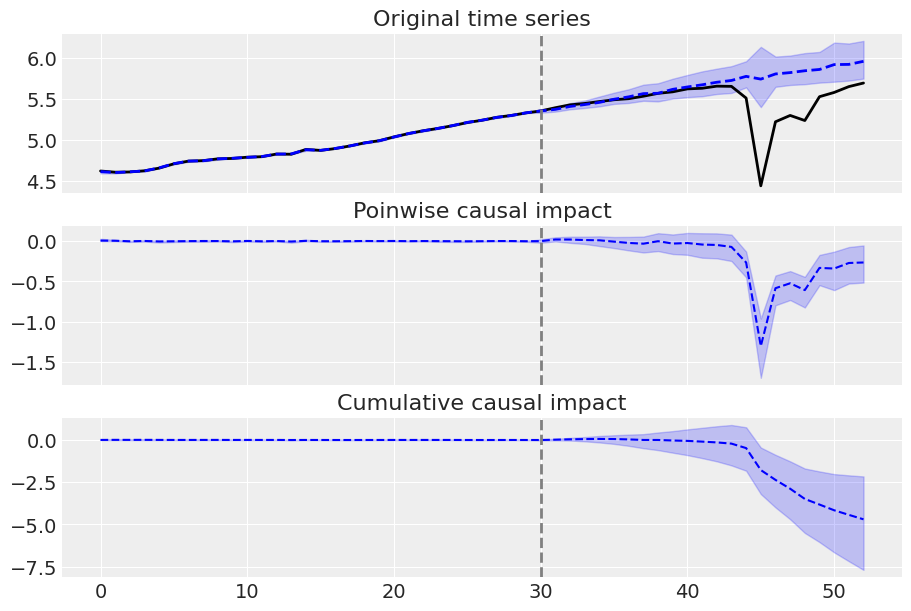

In [58]:
impact.plot()

In [59]:
impact.print_summary()

Posterior inference of the causal impact:

                               Average            Cumulative     
Actual                           5.45               125.44       

Prediction (s.d.)            5.66 (0.07)        130.14 (1.59)    
95% CI                       [5.55, 5.79]      [127.60, 133.13]  

Absolute effect (s.d.)       -0.20 (0.07)        -4.70 (1.59)    
95% CI                      [-0.33, -0.09]      [-7.70, -2.16]   

Relative effect (s.d.)      -3.60% (1.17%)      -3.60% (1.17%)   
95% CI                     [-5.78%, -1.69%]    [-5.78%, -1.69%]  

Posterior tail-area probability p: 0.0149
Posterior prob of a causal effect: 98.51%

